# Лабораторная работа №1 NLP Южаков Максим 19БИ-3

В начале ноутбука добавьте небольшое резюме - что Вами было сделано в ноутбуке: что попробовали, какие результаты получили.
- Была развита CNN архитектура посредством применения BatchNormalization,GroupNormalization, увеличения количества слоев и использования параллельных сверточных слоев для разных энкодеров. В результате было выявлено, что наилучшие результаты, по ряду метрик (loss,mse,mae) получены моделью с BatchNorm. trainloss = 1.3, mse = 0.3, mae = 0.7
- Проанализировано применение pooling слоев
- Использованы предобученне эмбеддинги, с ними получился наилучший результат
- Использованы реккурентные слои вместо сверточных. Модели оказались нестабильными, но показатели хорошие

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [140]:
data = pd.read_csv("/content/drive/MyDrive/nlp/Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

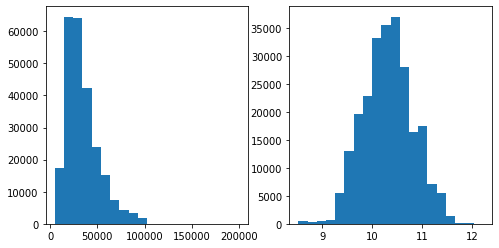

In [141]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [142]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
188176,71685886,CNC Precision Machinist,CNC Precision Machinist East Midlands Salary: ...,East Midlands,East Midlands,NaN,permanent,Grosvenor House,Engineering Jobs,34k pa,34000,jobsite.co.uk,10.434145
127848,70075371,Teacher (**** FTE) P****,Job Description Teacher (**** FTE) Newark Pri...,Scotland,Scotland,full_time,contract,NEWARK PRIMARY SCHOOL,Teaching Jobs,"25,716 - 34,200",29958,jobs.guardian.co.uk,10.307585
180286,71571237,"Business Support Administrator, Swaffham",This is a **** month fixed term contract. Scop...,Norwich,Norwich,full_time,NaN,Scope,Admin Jobs,"15,134.00 per year",15134,Jobcentre Plus,9.624765


In [143]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

In [144]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [145]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [146]:
token_to_id = {t: i for i, t in enumerate(tokens)}

In [147]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
    if not max_len:
        max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


In [148]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [149]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.1, random_state=77)
data_train, data_val = train_test_split(data_train, test_size=0.1, random_state=77)
data_test.index = range(len(data_test))
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Test size = ", len(data_test))
print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Test size =  24477
Train size =  198261
Validation size =  22030


In [150]:
import torch
def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [151]:
import torch
import torch.nn as nn
import torch.functional as F
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.BatchNorm1d(hid_size*2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [152]:
model = SalaryPredictor()

In [153]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [154]:
def iterate_minibatches(data, batch_size=256, max_len=None, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)
        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len, **kwargs)
            yield batch
        
        if not cycle: break

In [155]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [156]:
DEVICE

device(type='cuda')

In [157]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

Добавьте в пайплайн

- Batch Norm (nn.BatchNorm), 
- LayerNorm...
- Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы
- Больше слоев...
- Добавьте раннюю остановку

In [ ]:
def train(model, num_epochs, train_loader, val_loader, optimizer, criterion):
    train_cases = 0
    test_cases = 0
    best_metric = 9999
    best_epoch = 9999
    best_loss = 9999
    train_loss, mse_val, mae_val = [], [], []
    for epoch in range(EPOCHS):
        print(f"epoch: {epoch}")
        for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data_train, 
                        batch_size=BATCH_SIZE, 
                        device=DEVICE)), 
                    total=len(data_train) // BATCH_SIZE
            ):
            model.train()
            pred = model(batch)
            optimizer.zero_grad()
            loss = criterion(pred, batch[TARGET_COLUMN])
            loss.backward()
            optimizer.step()

            if i % 100 == 99:
                print('train_loss', loss.item())
                mse,mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
                mse_val.append(mse)
                mae_val.append(mae)
                train_loss.append(float(loss.item()))
                if float(loss.item()) < best_loss:
                    best_loss = float(loss.item())
        epoch = best_loss
        best_loss = 9999
        if epoch > best_epoch:
            break
        else:
            best_epoch = epoch
    return {"train_loss": train_loss, 
            "mse_val": mse_val, 
            "mae_val": mae_val}

In [ ]:
def print_loss(train_loss):
    plt.plot(train_loss, label='Train Loss')
    plt.title("Train Loss:")
    plt.ylabel('Loss')
    plt.xlabel('Iter')
    plt.legend(loc="upper left")
    plt.show()

In [ ]:
def print_mse(mse_val, test=False, title=None):
    plt.plot(mse_val, label=f'MSE ({"validation" if test else "test"} data)')
    plt.title("MSE")
    plt.ylabel('MSE')
    plt.xlabel('Iter')
    plt.legend(loc="upper left")
    plt.show()

In [ ]:
def print_mae(mae_val, test=False, title=None):
    plt.plot(mae_val, label=f'MAE ({"validation" if test else "test"} data)')
    plt.title("MAE")
    plt.ylabel('MAE')
    plt.xlabel('Iter')
    plt.legend(loc="upper left")
    plt.show()

In [ ]:
def print_best(model):
  print("Best loss: ",min(model['train_loss']))
  print("Best MSE: ",min(model['mse_val']))
  print("Best MAE: ",min(model['mae_val']))

Batch Norm (nn.BatchNorm)

In [ ]:
class SalaryPredictor_BN(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.BatchNorm1d(hid_size*2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictor_BN().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_BN = train(model, 3, data_train, data_val, optimizer, criterion)

epoch: 0


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 103.00543212890625
val results:
Mean square error: 26.23694
Mean absolute error: 2.55789
train_loss 92.16461181640625
val results:
Mean square error: 23.57319
Mean absolute error: 2.42336
train_loss 81.21033477783203
val results:
Mean square error: 20.84750
Mean absolute error: 2.27680
train_loss 68.08136749267578
val results:
Mean square error: 17.83112
Mean absolute error: 2.10325
train_loss 55.656585693359375
val results:
Mean square error: 14.82274
Mean absolute error: 1.91086
train_loss 41.009979248046875
val results:
Mean square error: 11.23821
Mean absolute error: 1.64549
train_loss 28.917593002319336
val results:
Mean square error: 8.82031
Mean absolute error: 1.43910
train_loss 19.107511520385742
val results:
Mean square error: 6.41019
Mean absolute error: 1.21607
train_loss 11.01987361907959
val results:
Mean square error: 4.13766
Mean absolute error: 0.94960
train_loss 5.469884872436523
val results:
Mean square error: 1.96998
Mean absolute error: 0.62220
train_los

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.7024485468864441
val results:
Mean square error: 0.41009
Mean absolute error: 0.21801
train_loss 0.8033965826034546
val results:
Mean square error: 0.36014
Mean absolute error: 0.20660
train_loss 0.38294756412506104
val results:
Mean square error: 0.31863
Mean absolute error: 0.19965
train_loss 0.48903295397758484
val results:
Mean square error: 0.28287
Mean absolute error: 0.18719
train_loss 0.6415387988090515
val results:
Mean square error: 0.20781
Mean absolute error: 0.16736
train_loss 0.48460590839385986
val results:
Mean square error: 0.17428
Mean absolute error: 0.16165
train_loss 0.38117551803588867
val results:
Mean square error: 0.12119
Mean absolute error: 0.13180
train_loss 0.17649953067302704
val results:
Mean square error: 0.07203
Mean absolute error: 0.10169
train_loss 0.2904804050922394
val results:
Mean square error: 0.06719
Mean absolute error: 0.09810
train_loss 0.20757047832012177
val results:
Mean square error: 0.07409
Mean absolute error: 0.10401
trai

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.233390212059021
val results:
Mean square error: 0.05772
Mean absolute error: 0.09374
train_loss 0.18599765002727509
val results:
Mean square error: 0.05526
Mean absolute error: 0.09194
train_loss 0.14119493961334229
val results:
Mean square error: 0.05248
Mean absolute error: 0.08875
train_loss 0.23029547929763794
val results:
Mean square error: 0.04812
Mean absolute error: 0.08526
train_loss 0.1738024353981018
val results:
Mean square error: 0.05196
Mean absolute error: 0.08906
train_loss 0.18112824857234955
val results:
Mean square error: 0.04193
Mean absolute error: 0.07915
train_loss 0.16065126657485962
val results:
Mean square error: 0.04515
Mean absolute error: 0.08238
train_loss 0.15079310536384583
val results:
Mean square error: 0.04094
Mean absolute error: 0.07845
train_loss 0.14088162779808044
val results:
Mean square error: 0.03921
Mean absolute error: 0.07645
train_loss 0.17263631522655487
val results:
Mean square error: 0.07303
Mean absolute error: 0.10906
tra

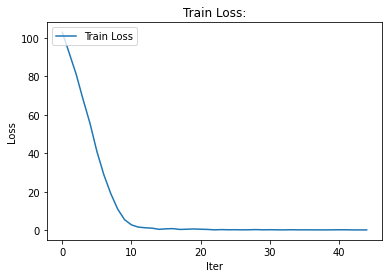

In [ ]:
print_loss(model_BN["train_loss"])

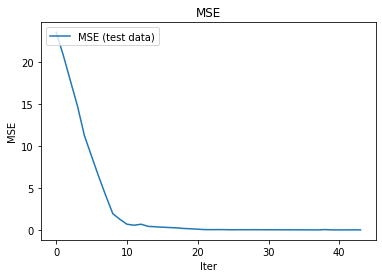

In [ ]:
print_mse(model_BN["mse_val"][1:])

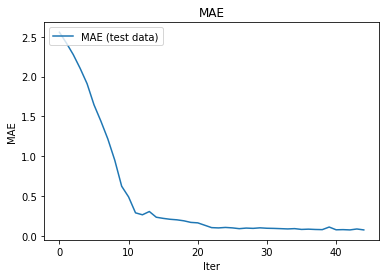

In [ ]:
print_mae(model_BN["mae_val"])

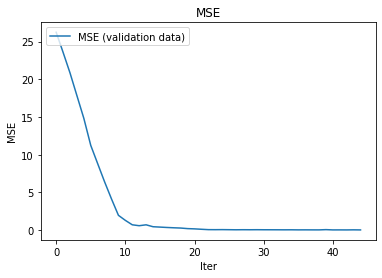

In [ ]:
print_mse(model_BN["mse_val"],True)

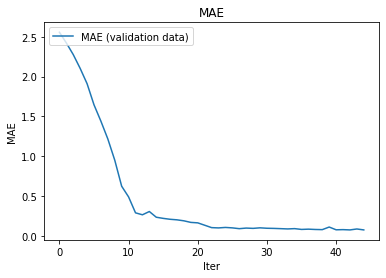

In [ ]:
print_mae(model_BN["mae_val"],True)

In [ ]:
print_best(model_BN)

Best loss:  0.13196228444576263
Best MSE:  0.035469893086163294
Best MAE:  0.07288947684227387


LayerNorm

Из-за неограниченности длинны слова, с LayerNorm придется использовать каждый раз новый слой, поэтому было решено использовать вместо LN - Group Normalization

In [ ]:
class SalaryPredictor_GN(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.GroupNorm(num_groups=4,num_channels=hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.GroupNorm(num_groups=4,num_channels=hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.GroupNorm(num_groups=4,num_channels=hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.GroupNorm(num_groups=4,num_channels=hid_size*2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.GroupNorm(num_groups=4,num_channels=hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )


        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        # print(title_embeddings.squeeze().size()[1])
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictor_GN().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_GN = train(model, 3, data_train, data_val, optimizer, criterion)

epoch: 0


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 100.64920806884766
val results:
Mean square error: 24.87653
Mean absolute error: 2.49079
train_loss 85.25033569335938
val results:
Mean square error: 21.30154
Mean absolute error: 2.30440
train_loss 66.38599395751953
val results:
Mean square error: 16.75028
Mean absolute error: 2.04266
train_loss 48.178199768066406
val results:
Mean square error: 11.84965
Mean absolute error: 1.71677
train_loss 29.781707763671875
val results:
Mean square error: 7.40991
Mean absolute error: 1.35549
train_loss 16.45282554626465
val results:
Mean square error: 4.02296
Mean absolute error: 0.99530
train_loss 7.188767910003662
val results:
Mean square error: 1.86800
Mean absolute error: 0.67222
train_loss 2.811948299407959
val results:
Mean square error: 0.74703
Mean absolute error: 0.41436
train_loss 0.9246852993965149
val results:
Mean square error: 0.27651
Mean absolute error: 0.23422
train_loss 0.5101637840270996
val results:
Mean square error: 0.11737
Mean absolute error: 0.14019
train_loss 

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.21989959478378296
val results:
Mean square error: 0.06050
Mean absolute error: 0.09894
train_loss 0.26445555686950684
val results:
Mean square error: 0.06049
Mean absolute error: 0.09900
train_loss 0.24786503612995148
val results:
Mean square error: 0.06049
Mean absolute error: 0.09897
train_loss 0.2535860538482666
val results:
Mean square error: 0.06049
Mean absolute error: 0.09899
train_loss 0.25623488426208496
val results:
Mean square error: 0.06050
Mean absolute error: 0.09903
train_loss 0.26373299956321716
val results:
Mean square error: 0.06049
Mean absolute error: 0.09901
train_loss 0.19749119877815247
val results:
Mean square error: 0.06049
Mean absolute error: 0.09902
train_loss 0.29137519001960754
val results:
Mean square error: 0.06049
Mean absolute error: 0.09900
train_loss 0.2554335594177246
val results:
Mean square error: 0.06049
Mean absolute error: 0.09899
train_loss 0.20675620436668396
val results:
Mean square error: 0.06050
Mean absolute error: 0.09904
tr

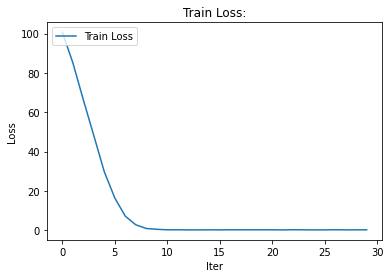

In [ ]:
print_loss(model_GN["train_loss"])

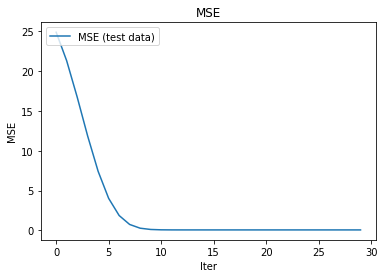

In [ ]:
print_mse(model_GN["mse_val"])

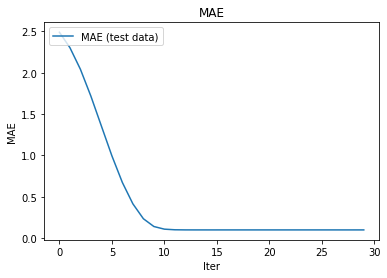

In [ ]:
print_mae(model_GN["mae_val"])

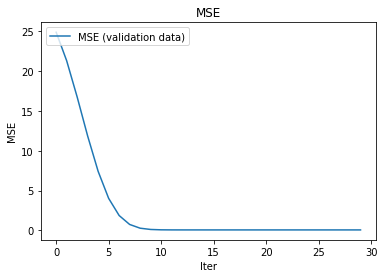

In [ ]:
print_mse(model_GN["mse_val"],True)

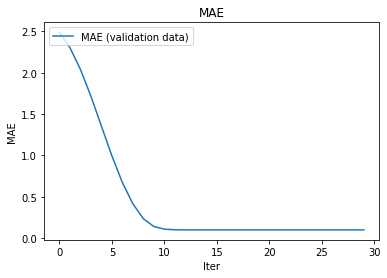

In [ ]:
print_mae(model_GN["mae_val"],True)

In [ ]:
print_best(model_GN)

Best loss:  0.19547994434833527
Best MSE:  0.0604899908076821
Best MAE:  0.09893105347032492


Результаты получились хуже, чем с Batch Normalization

Параллельные сверточные Слои

In [ ]:
class SalaryPredictor_Parallel(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.GroupNorm(num_groups=4,num_channels=hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.title_encoder2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.GroupNorm(num_groups=4,num_channels=hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1))
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.GroupNorm(num_groups=4,num_channels=hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.GroupNorm(num_groups=4,num_channels=hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.GroupNorm(num_groups=4,num_channels=hid_size*2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 5, hid_size),
            nn.GroupNorm(num_groups=4,num_channels=hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features1 = self.title_encoder1(title_embeddings).squeeze()
        title_features2 = self.title_encoder2(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features1,title_features2, description_features, categorical_features], dim=1)
        # print(title_features1.size())
        # print(title_features2.size())
        # print(description_features.size())
        # print(categorical_features.size())
        # print(features.size())
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictor_Parallel().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_P = train(model, 3, data_train, data_val, optimizer, criterion)

epoch: 0


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 86.75004577636719
val results:
Mean square error: 21.51215
Mean absolute error: 2.31580
train_loss 70.19381713867188
val results:
Mean square error: 17.86774
Mean absolute error: 2.10993
train_loss 54.49784851074219
val results:
Mean square error: 13.85642
Mean absolute error: 1.85714
train_loss 39.13377380371094
val results:
Mean square error: 9.76186
Mean absolute error: 1.55735
train_loss 24.596590042114258
val results:
Mean square error: 6.08123
Mean absolute error: 1.22686
train_loss 12.862447738647461
val results:
Mean square error: 3.27346
Mean absolute error: 0.89624
train_loss 5.768884181976318
val results:
Mean square error: 1.49987
Mean absolute error: 0.59987
train_loss 2.6575264930725098
val results:
Mean square error: 0.59447
Mean absolute error: 0.36563
train_loss 0.8929507732391357
val results:
Mean square error: 0.22289
Mean absolute error: 0.20527
train_loss 0.3575865626335144
val results:
Mean square error: 0.10125
Mean absolute error: 0.12903
train_loss 0

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.2054799497127533
val results:
Mean square error: 0.06049
Mean absolute error: 0.09897
train_loss 0.2500225305557251
val results:
Mean square error: 0.06050
Mean absolute error: 0.09905
train_loss 0.2518694996833801
val results:
Mean square error: 0.06049
Mean absolute error: 0.09900
train_loss 0.2521476447582245
val results:
Mean square error: 0.06049
Mean absolute error: 0.09899
train_loss 0.2692719101905823
val results:
Mean square error: 0.06049
Mean absolute error: 0.09896
train_loss 0.23511895537376404
val results:
Mean square error: 0.06049
Mean absolute error: 0.09897
train_loss 0.2744747996330261
val results:
Mean square error: 0.06049
Mean absolute error: 0.09901
train_loss 0.19637835025787354
val results:
Mean square error: 0.06049
Mean absolute error: 0.09900
train_loss 0.22328642010688782
val results:
Mean square error: 0.06050
Mean absolute error: 0.09893
train_loss 0.26919105648994446
val results:
Mean square error: 0.06049
Mean absolute error: 0.09897
train_

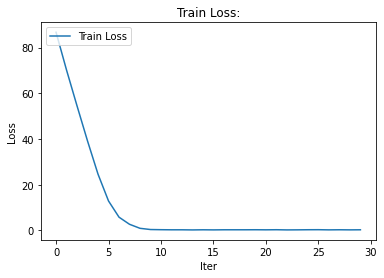

In [ ]:
print_loss(model_P["train_loss"])

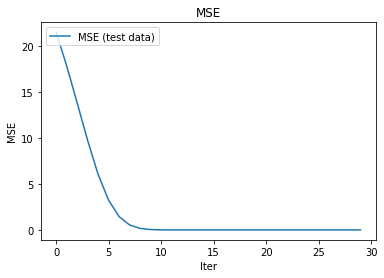

In [ ]:
print_mse(model_P["mse_val"])

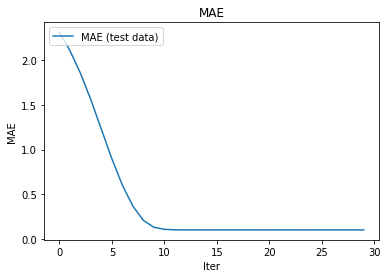

In [ ]:
print_mae(model_P["mae_val"])

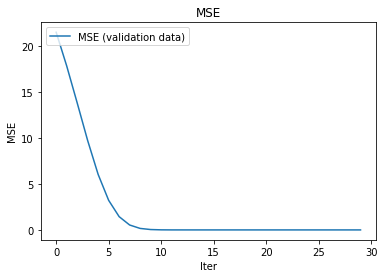

In [ ]:
print_mse(model_P["mse_val"],True)

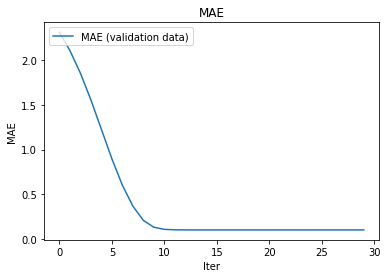

In [ ]:
print_mae(model_P["mae_val"],True)

In [ ]:
print_best(model_P)

Best loss:  0.19049391150474548
Best MSE:  0.060490106571616464
Best MAE:  0.09892953200147331


Результаты с параллельными слоями не сильно поменялись относительно обычного GroupNorm

**Больше слоев**

In [ ]:
class SalaryPredictor_2(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder_1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.GroupNorm(4, hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.title_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.GroupNorm(4, hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder_1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.GroupNorm(4, hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.GroupNorm(4, hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.GroupNorm(4, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.GroupNorm(4, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size*3),
            nn.GroupNorm(num_groups=4,num_channels=hid_size*3),
            nn.Linear(hid_size * 3, hid_size*2),
            nn.GroupNorm(num_groups=4,num_channels=hid_size*2),
            nn.Linear(hid_size * 2, hid_size),
            nn.GroupNorm(num_groups=4,num_channels=hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )


        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder_1(title_embeddings).squeeze() + \
                         self.title_encoder_2(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder_1(description_embeddings).squeeze() + \
                               self.description_encoder_2(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictor_2().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_2 = train(model, 3, data_train, data_val, optimizer, criterion)

epoch: 0


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 96.32719421386719
val results:
Mean square error: 23.97244
Mean absolute error: 2.44499
train_loss 83.36407470703125
val results:
Mean square error: 20.56518
Mean absolute error: 2.26411
train_loss 66.23433685302734
val results:
Mean square error: 16.67264
Mean absolute error: 2.03790
train_loss 51.17298889160156
val results:
Mean square error: 12.54394
Mean absolute error: 1.76660
train_loss 35.58845138549805
val results:
Mean square error: 8.63705
Mean absolute error: 1.46429
train_loss 21.452037811279297
val results:
Mean square error: 5.35177
Mean absolute error: 1.15014
train_loss 11.98261833190918
val results:
Mean square error: 2.93579
Mean absolute error: 0.84784
train_loss 5.797416687011719
val results:
Mean square error: 1.40801
Mean absolute error: 0.58041
train_loss 2.5114340782165527
val results:
Mean square error: 0.59635
Mean absolute error: 0.36627
train_loss 0.9098984003067017
val results:
Mean square error: 0.24032
Mean absolute error: 0.21497
train_loss 0.

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.26314613223075867
val results:
Mean square error: 0.06050
Mean absolute error: 0.09893
train_loss 0.24880880117416382
val results:
Mean square error: 0.06049
Mean absolute error: 0.09897
train_loss 0.21633435785770416
val results:
Mean square error: 0.06049
Mean absolute error: 0.09898
train_loss 0.2012590616941452
val results:
Mean square error: 0.06049
Mean absolute error: 0.09902
train_loss 0.23512554168701172
val results:
Mean square error: 0.06049
Mean absolute error: 0.09898
train_loss 0.22861281037330627
val results:
Mean square error: 0.06049
Mean absolute error: 0.09896
train_loss 0.24076557159423828
val results:
Mean square error: 0.06050
Mean absolute error: 0.09903
train_loss 0.2829672396183014
val results:
Mean square error: 0.06050
Mean absolute error: 0.09903
train_loss 0.22281396389007568
val results:
Mean square error: 0.06049
Mean absolute error: 0.09895
train_loss 0.23464460670948029
val results:
Mean square error: 0.06049
Mean absolute error: 0.09901
tr

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.18869781494140625
val results:
Mean square error: 0.06049
Mean absolute error: 0.09899
train_loss 0.24435916543006897
val results:
Mean square error: 0.06049
Mean absolute error: 0.09902
train_loss 0.229817196726799
val results:
Mean square error: 0.06049
Mean absolute error: 0.09896
train_loss 0.22102710604667664
val results:
Mean square error: 0.06049
Mean absolute error: 0.09899
train_loss 0.2166868895292282
val results:
Mean square error: 0.06049
Mean absolute error: 0.09900
train_loss 0.2759200930595398
val results:
Mean square error: 0.06050
Mean absolute error: 0.09903
train_loss 0.2729126214981079
val results:
Mean square error: 0.06049
Mean absolute error: 0.09900
train_loss 0.2865675389766693
val results:
Mean square error: 0.06049
Mean absolute error: 0.09899
train_loss 0.22836537659168243
val results:
Mean square error: 0.06049
Mean absolute error: 0.09897
train_loss 0.2653157114982605
val results:
Mean square error: 0.06052
Mean absolute error: 0.09909
train_l

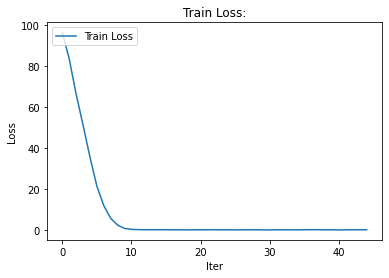

In [ ]:
print_loss(model_2["train_loss"])

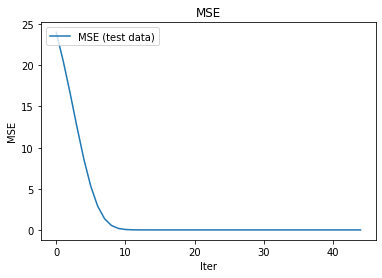

In [ ]:
print_mse(model_2["mse_val"])

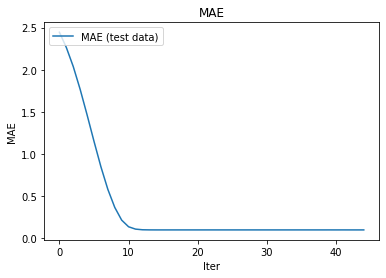

In [ ]:
print_mae(model_2["mae_val"])

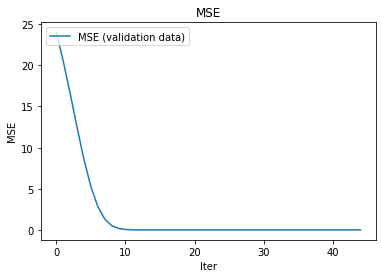

In [ ]:
print_mse(model_2["mse_val"],True)

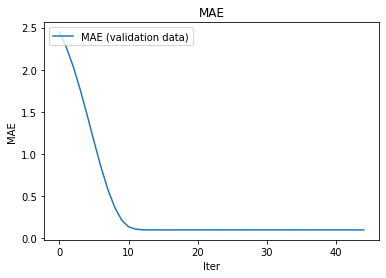

In [ ]:
print_mae(model_2["mae_val"],True)

In [ ]:
print_best(model_2)

Best loss:  0.18103227019309998
Best MSE:  0.060489737229540166
Best MAE:  0.09893050221349463


Результаты держатся на том же уровне

1.4 Ранняя остановка

Ранняя остановка применена уже в train функции, которой обучаются все модели

2. Pooling слои стандартные

Опишите своими словами как работает Pooling слой.

pooling layer испоользуется для уменьшение размера выходных данных по сравнению со входными. Такое уменьшение происходит засчет того, что на Pooling слое происходит операция суммирования блоков пикселей изображения или выделение наибольшего значения из них, затем на выходе остаются только несколько выбранных блоков, в зависимости от шага и размера сетки.

Взять максимум по временной компоненте (незавимисо для каждой фичи)

In [ ]:
class SalaryPredictor_Max(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).max(dim=2)[0]

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).max(dim=2)[0]

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictor_Max().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_max = train(model, 3, data_train, data_val, optimizer, criterion)

epoch: 0


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 98.7432632446289
val results:
Mean square error: 24.49373
Mean absolute error: 2.46952
train_loss 90.605712890625
val results:
Mean square error: 22.05558
Mean absolute error: 2.34388
train_loss 79.98643493652344
val results:
Mean square error: 19.46735
Mean absolute error: 2.20102
train_loss 66.22892761230469
val results:
Mean square error: 16.46800
Mean absolute error: 2.02337
train_loss 54.547576904296875
val results:
Mean square error: 13.53699
Mean absolute error: 1.83229
train_loss 40.679168701171875
val results:
Mean square error: 10.32362
Mean absolute error: 1.59722
train_loss 28.274967193603516
val results:
Mean square error: 7.11162
Mean absolute error: 1.31864
train_loss 17.88124656677246
val results:
Mean square error: 5.81556
Mean absolute error: 1.19135
train_loss 10.148539543151855
val results:
Mean square error: 2.53751
Mean absolute error: 0.76754
train_loss 5.117964267730713
val results:
Mean square error: 1.46865
Mean absolute error: 0.57320
train_loss 2.

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.32428181171417236
val results:
Mean square error: 0.07039
Mean absolute error: 0.10053
train_loss 0.26277652382850647
val results:
Mean square error: 0.06793
Mean absolute error: 0.09740
train_loss 0.19313134253025055
val results:
Mean square error: 0.06009
Mean absolute error: 0.09046
train_loss 0.2974607050418854
val results:
Mean square error: 0.06891
Mean absolute error: 0.10039
train_loss 0.4798815846443176
val results:
Mean square error: 0.06304
Mean absolute error: 0.09251
train_loss 0.2130020260810852
val results:
Mean square error: 0.05652
Mean absolute error: 0.08890
train_loss 0.19574499130249023
val results:
Mean square error: 0.06151
Mean absolute error: 0.09411
train_loss 0.31053537130355835
val results:
Mean square error: 0.05237
Mean absolute error: 0.08566
train_loss 0.25621363520622253
val results:
Mean square error: 0.06407
Mean absolute error: 0.09602
train_loss 0.34273892641067505
val results:
Mean square error: 0.07312
Mean absolute error: 0.10509
tra

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.17201051115989685
val results:
Mean square error: 0.04668
Mean absolute error: 0.08136
train_loss 0.24151813983917236
val results:
Mean square error: 0.05568
Mean absolute error: 0.09005
train_loss 0.3259439468383789
val results:
Mean square error: 0.06090
Mean absolute error: 0.09632
train_loss 0.2026607096195221
val results:
Mean square error: 0.04439
Mean absolute error: 0.07944
train_loss 0.23588618636131287
val results:
Mean square error: 0.04419
Mean absolute error: 0.07918
train_loss 0.2195981740951538
val results:
Mean square error: 0.04512
Mean absolute error: 0.08016
train_loss 0.48238950967788696
val results:
Mean square error: 0.05392
Mean absolute error: 0.08935
train_loss 0.2349289506673813
val results:
Mean square error: 0.04823
Mean absolute error: 0.08367
train_loss 0.507378101348877
val results:
Mean square error: 0.04520
Mean absolute error: 0.08033
train_loss 0.41896697878837585
val results:
Mean square error: 0.04436
Mean absolute error: 0.07998
train_

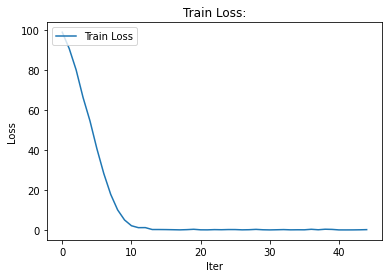

In [ ]:
print_loss(model_max["train_loss"])

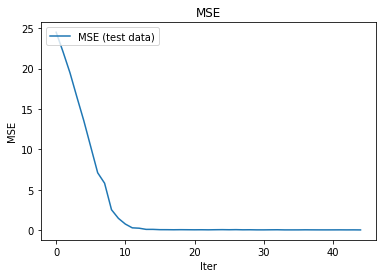

In [ ]:
print_mse(model_max["mse_val"])

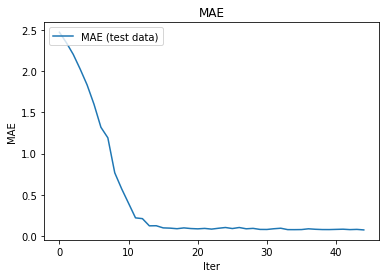

In [ ]:
print_mae(model_max["mae_val"])

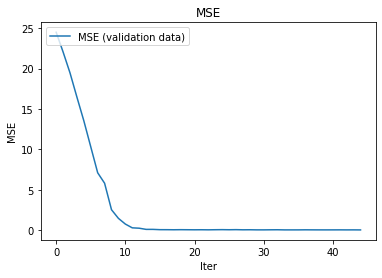

In [ ]:
print_mse(model_max["mse_val"],True)

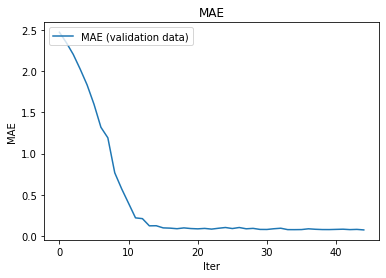

In [ ]:
print_mae(model_max["mae_val"],True)

In [ ]:
print_best(model_max)

Best loss:  0.16428470611572266
Best MSE:  0.04029202874685298
Best MAE:  0.07589546931272297


Взять среднее по временной компоненте (исключая PAD символы)

In [ ]:
class SalaryPredictor_Mean(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

    def mean(self, batch):
        with torch.no_grad():
            return batch.sum(axis=2) / (batch.sum(axis=1) > 0).sum(axis=1).view(-1,1).float()

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.mean(self.title_encoder(title_embeddings))

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.mean(self.description_encoder(description_embeddings))

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictor_Mean().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_mean = train(model, 3, data_train, data_val, optimizer, criterion)

epoch: 0


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 99.92198181152344
val results:
Mean square error: 24.54036
Mean absolute error: 2.47362
train_loss 89.94804382324219
val results:
Mean square error: 22.31697
Mean absolute error: 2.35824
train_loss 76.08637237548828
val results:
Mean square error: 18.93624
Mean absolute error: 2.17117
train_loss 59.0078125
val results:
Mean square error: 14.67130
Mean absolute error: 1.90857
train_loss 40.7729377746582
val results:
Mean square error: 10.13409
Mean absolute error: 1.58217
train_loss 24.019695281982422
val results:
Mean square error: 6.18025
Mean absolute error: 1.22800
train_loss 12.318309783935547
val results:
Mean square error: 2.90279
Mean absolute error: 0.82691
train_loss 5.757095813751221
val results:
Mean square error: 1.53078
Mean absolute error: 0.58156
train_loss 2.008613109588623
val results:
Mean square error: 0.61281
Mean absolute error: 0.34190
train_loss 1.0156923532485962
val results:
Mean square error: 0.21894
Mean absolute error: 0.19088
train_loss 0.4219720

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.17310947179794312
val results:
Mean square error: 0.04833
Mean absolute error: 0.08547
train_loss 0.19044622778892517
val results:
Mean square error: 0.04121
Mean absolute error: 0.07875
train_loss 0.2471233606338501
val results:
Mean square error: 0.04593
Mean absolute error: 0.08401
train_loss 0.3288801908493042
val results:
Mean square error: 0.04053
Mean absolute error: 0.07797
train_loss 0.19436827301979065
val results:
Mean square error: 0.04551
Mean absolute error: 0.08387
train_loss 0.12139604985713959
val results:
Mean square error: 0.04124
Mean absolute error: 0.07901
train_loss 0.2377617359161377
val results:
Mean square error: 0.05512
Mean absolute error: 0.09303
train_loss 0.1139092668890953
val results:
Mean square error: 0.03871
Mean absolute error: 0.07631
train_loss 0.17281490564346313
val results:
Mean square error: 0.04050
Mean absolute error: 0.07783
train_loss 0.1729302704334259
val results:
Mean square error: 0.03834
Mean absolute error: 0.07584
train

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.20297864079475403
val results:
Mean square error: 0.03959
Mean absolute error: 0.07768
train_loss 0.12109044939279556
val results:
Mean square error: 0.04076
Mean absolute error: 0.07823
train_loss 0.10992558300495148
val results:
Mean square error: 0.03940
Mean absolute error: 0.07671
train_loss 0.11443130671977997
val results:
Mean square error: 0.03904
Mean absolute error: 0.07622
train_loss 0.16782784461975098
val results:
Mean square error: 0.04208
Mean absolute error: 0.07974
train_loss 0.18646061420440674
val results:
Mean square error: 0.03892
Mean absolute error: 0.07609
train_loss 0.14899419248104095
val results:
Mean square error: 0.05286
Mean absolute error: 0.09068
train_loss 0.1601942777633667
val results:
Mean square error: 0.03636
Mean absolute error: 0.07370
train_loss 0.10810476541519165
val results:
Mean square error: 0.03646
Mean absolute error: 0.07359
train_loss 0.19582653045654297
val results:
Mean square error: 0.03724
Mean absolute error: 0.07466
t

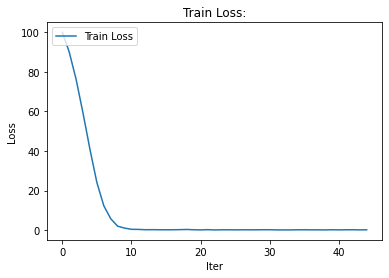

In [ ]:
print_loss(model_mean["train_loss"])

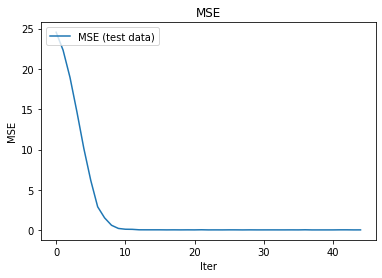

In [ ]:
print_mse(model_mean["mse_val"])

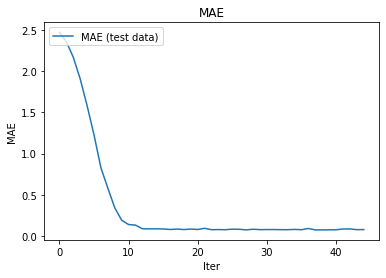

In [ ]:
print_mae(model_mean["mae_val"])

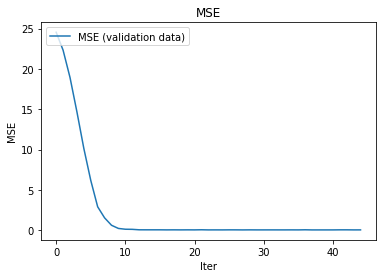

In [ ]:
print_mse(model_mean["mse_val"],True)

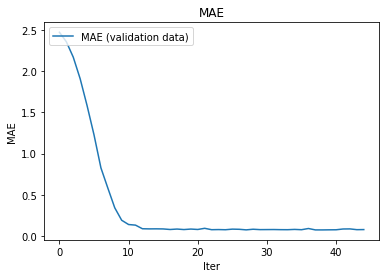

In [ ]:
print_mae(model_mean["mae_val"],True)

In [ ]:
print_best(model_mean)

Best loss:  0.10810476541519165
Best MSE:  0.03635625618730666
Best MAE:  0.07358633713915169


3.Используйте предобученные эмбеддинги

Загрузите предобученные эмбеддинги с помощью gensim.downloader.load

Так как с word2vec моделью при загрузке произошли проблемы(прерывался connection) был выбран glove-twitter, объем поменьше

In [ ]:
import gensim.downloader as api

wv = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


Используйте метод from_pretrained слоя torch.nn.Embedding для инициализации эмбеддингов с помощью предобученных весов. Можете попбровать несколько типов предобученных эмбеддингов.

In [ ]:
import gensim

id_to_tocken = {value:key for key, value in token_to_id.items()}

weight = torch.zeros(len(token_to_id)+1, wv.vector_size)

for i in range(len(token_to_id)+1):
    try:
        weight[i, :] = torch.from_numpy(wv.get_vector(id_to_tocken[i]))
    except:
        continue
embedding = nn.Embedding.from_pretrained(weight, freeze=False)
embedding_freeze = nn.Embedding.from_pretrained(weight, freeze=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  if __name__ == '__main__':


Проведите эксперементы с обучаемыми/замороженными весами эмбеддингов. Используйте одни и те же эмбеддинги для Title и FullDescription.

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=25):
        super().__init__()
        self.embedder = embedding
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.BatchNorm1d(hid_size*2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_wv = train(model, 3, data_train, data_val, optimizer, criterion)

epoch: 0


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 82.01405334472656
val results:
Mean square error: 19.66443
Mean absolute error: 2.21321
train_loss 50.536949157714844
val results:
Mean square error: 12.37275
Mean absolute error: 1.74953
train_loss 20.68054962158203
val results:
Mean square error: 5.70947
Mean absolute error: 1.17788
train_loss 5.904858589172363
val results:
Mean square error: 2.03415
Mean absolute error: 0.67112
train_loss 1.0598256587982178
val results:
Mean square error: 0.75946
Mean absolute error: 0.37413
train_loss 0.31612664461135864
val results:
Mean square error: 0.59287
Mean absolute error: 0.31786
train_loss 0.3456922769546509
val results:
Mean square error: 0.33451
Mean absolute error: 0.23678
train_loss 0.1451604962348938
val results:
Mean square error: 0.37240
Mean absolute error: 0.23654
train_loss 0.19471710920333862
val results:
Mean square error: 0.35149
Mean absolute error: 0.24736
train_loss 0.18572795391082764
val results:
Mean square error: 0.28906
Mean absolute error: 0.20547
train_lo

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.12107837945222855
val results:
Mean square error: 0.17372
Mean absolute error: 0.16083
train_loss 0.13234791159629822
val results:
Mean square error: 0.13063
Mean absolute error: 0.14209
train_loss 0.14512301981449127
val results:
Mean square error: 0.12331
Mean absolute error: 0.13826
train_loss 0.15659520030021667
val results:
Mean square error: 0.15877
Mean absolute error: 0.16338
train_loss 0.10405877232551575
val results:
Mean square error: 0.07512
Mean absolute error: 0.11257
train_loss 0.08825451880693436
val results:
Mean square error: 0.08220
Mean absolute error: 0.11239
train_loss 0.12317562103271484
val results:
Mean square error: 0.09387
Mean absolute error: 0.12019
train_loss 0.17782250046730042
val results:
Mean square error: 0.12888
Mean absolute error: 0.14355
train_loss 0.11752332001924515
val results:
Mean square error: 0.10732
Mean absolute error: 0.13246
train_loss 0.15077781677246094
val results:
Mean square error: 0.06906
Mean absolute error: 0.10658


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.14380408823490143
val results:
Mean square error: 0.06179
Mean absolute error: 0.09804
train_loss 0.08679571747779846
val results:
Mean square error: 0.06768
Mean absolute error: 0.10282
train_loss 0.08668417483568192
val results:
Mean square error: 0.05330
Mean absolute error: 0.09079
train_loss 0.12970799207687378
val results:
Mean square error: 0.06271
Mean absolute error: 0.09984
train_loss 0.08334110677242279
val results:
Mean square error: 0.12292
Mean absolute error: 0.14934
train_loss 0.08400434255599976
val results:
Mean square error: 0.06082
Mean absolute error: 0.09877
train_loss 0.11300422251224518
val results:
Mean square error: 0.07361
Mean absolute error: 0.10881
train_loss 0.07882538437843323
val results:
Mean square error: 0.05291
Mean absolute error: 0.09153
train_loss 0.1124536544084549
val results:
Mean square error: 0.08173
Mean absolute error: 0.11556
train_loss 0.0751519724726677
val results:
Mean square error: 0.05564
Mean absolute error: 0.09219
tr

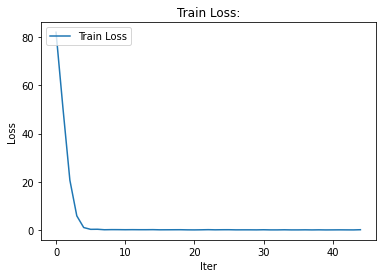

In [ ]:
print_loss(model_wv["train_loss"])

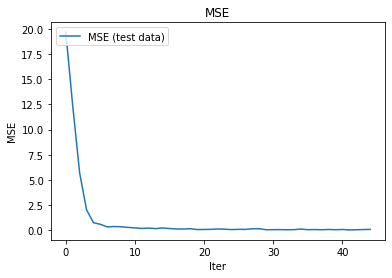

In [ ]:
print_mse(model_wv["mse_val"])

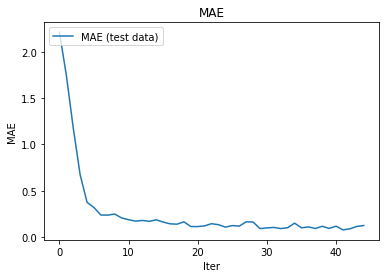

In [ ]:
print_mae(model_wv["mae_val"])

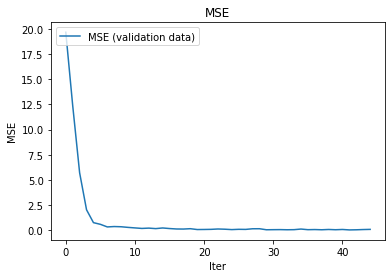

In [ ]:
print_mse(model_wv["mse_val"],True)

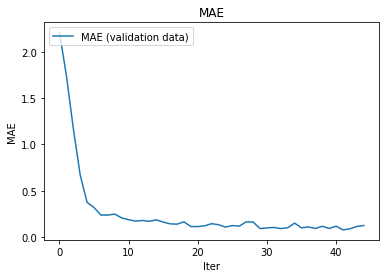

In [ ]:
print_mae(model_wv["mae_val"],True)

In [ ]:
print_best(model_wv)

Best loss:  0.0751519724726677
Best MSE:  0.037619213148348596
Best MAE:  0.07617208999016381


Результаты очень хорошие, лучше чем на первых моделях. На валидационных данных результаты менее стабильные

С замороженными весами

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=25):
        super().__init__()
        self.embedder = embedding_freeze
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.BatchNorm1d(hid_size*2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )


        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_wv_freeze = train(model, 3, data_train, data_val, optimizer, criterion)

epoch: 0


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 68.22329711914062
val results:
Mean square error: 17.74037
Mean absolute error: 2.10180
train_loss 35.513633728027344
val results:
Mean square error: 9.73312
Mean absolute error: 1.55198
train_loss 12.38735580444336
val results:
Mean square error: 3.66114
Mean absolute error: 0.94165
train_loss 2.4744696617126465
val results:
Mean square error: 1.07518
Mean absolute error: 0.47917
train_loss 0.5828497409820557
val results:
Mean square error: 0.29212
Mean absolute error: 0.21224
train_loss 0.43057966232299805
val results:
Mean square error: 0.30294
Mean absolute error: 0.22462
train_loss 0.25208622217178345
val results:
Mean square error: 0.18874
Mean absolute error: 0.16675
train_loss 0.2760254144668579
val results:
Mean square error: 0.15015
Mean absolute error: 0.14708
train_loss 0.19456380605697632
val results:
Mean square error: 0.17772
Mean absolute error: 0.15852
train_loss 0.2882719039916992
val results:
Mean square error: 0.14381
Mean absolute error: 0.14786
train_lo

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.12012061476707458
val results:
Mean square error: 0.08051
Mean absolute error: 0.11283
train_loss 0.17791929841041565
val results:
Mean square error: 0.05165
Mean absolute error: 0.08850
train_loss 0.1685541421175003
val results:
Mean square error: 0.05180
Mean absolute error: 0.08838
train_loss 0.18168017268180847
val results:
Mean square error: 0.04732
Mean absolute error: 0.08515
train_loss 0.15670835971832275
val results:
Mean square error: 0.04544
Mean absolute error: 0.08250
train_loss 0.180517315864563
val results:
Mean square error: 0.04971
Mean absolute error: 0.08834
train_loss 0.13453125953674316
val results:
Mean square error: 0.05020
Mean absolute error: 0.08715
train_loss 0.12619909644126892
val results:
Mean square error: 0.08590
Mean absolute error: 0.11851
train_loss 0.1299419403076172
val results:
Mean square error: 0.04644
Mean absolute error: 0.08620
train_loss 0.14127042889595032
val results:
Mean square error: 0.04395
Mean absolute error: 0.08099
trai

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss 0.1329163759946823
val results:
Mean square error: 0.03585
Mean absolute error: 0.07297
train_loss 0.13718679547309875
val results:
Mean square error: 0.07039
Mean absolute error: 0.10853
train_loss 0.11190789937973022
val results:
Mean square error: 0.04568
Mean absolute error: 0.08277
train_loss 0.15275180339813232
val results:
Mean square error: 0.05106
Mean absolute error: 0.09036
train_loss 0.1635160893201828
val results:
Mean square error: 0.03789
Mean absolute error: 0.07506
train_loss 0.10641126334667206
val results:
Mean square error: 0.07005
Mean absolute error: 0.10907
train_loss 0.12251962721347809
val results:
Mean square error: 0.03643
Mean absolute error: 0.07469
train_loss 0.08988424390554428
val results:
Mean square error: 0.04303
Mean absolute error: 0.08102
train_loss 0.20869594812393188
val results:
Mean square error: 0.04601
Mean absolute error: 0.08578
train_loss 0.12982815504074097
val results:
Mean square error: 0.02962
Mean absolute error: 0.06619
tr

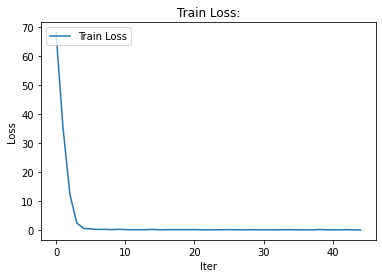

In [ ]:
print_loss(model_wv_freeze["train_loss"])

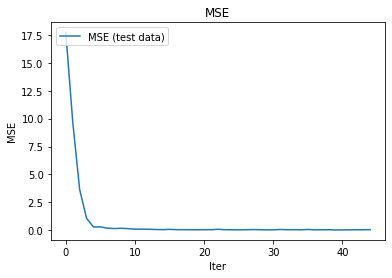

In [ ]:
print_mse(model_wv_freeze["mse_val"])

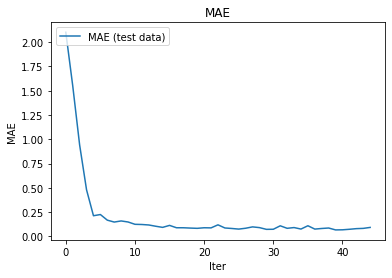

In [ ]:
print_mae(model_wv_freeze["mae_val"])

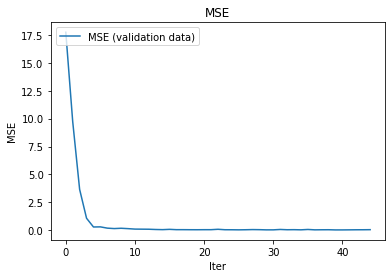

In [ ]:
print_mse(model_wv_freeze["mse_val"],True)

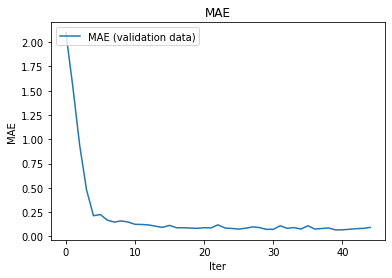

In [ ]:
print_mae(model_wv_freeze["mae_val"],True)

In [ ]:
print_best(model_wv_freeze)

Best loss:  0.08217109739780426
Best MSE:  0.029622563047905188
Best MAE:  0.06618628198700834


Loss с замороженными весами хуже, но MAE и MSE лучше, при этом, можно заметить, что на валидационных данных результаты менее стабильные, чем на тестовых

#4. Замените сверточные слои на рекуррентные

Замените сверточне слоим рекуррентными LSTM/GRU.

Пришлось поменять настройик длины при создании последовательности в матрицу

На lstm:

In [158]:
class SalaryPredictor_R(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, length=35, bidirectional=False):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.lstm = nn.LSTM(length, hid_size, 2)
        self.title_encoder = nn.Sequential(
            nn.GroupNorm(hid_size, hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.GroupNorm(hid_size, hid_size),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features, (_h, _h) = self.lstm(title_embeddings)
        title_features = self.title_encoder(title_features).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features, (_h, _c) = self.lstm(description_embeddings)
        description_features = self.description_encoder(description_features).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [177]:
def print_metrics_new(model, data, batch_size, max_len=35, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, max_len=max_len, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    if name != "train":
        print("%s results:" % (name or ""))
        print("Mean square error: %.5f" % mse)
        print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [160]:
def train_new(model, num_epochs, train_loader, val_loader, optimizer, criterion, max_len=35):
    best_loss = 999999
    finish = False
    train_loss, mse_valid, mae_valid = [], [], []
    for epoch in range(num_epochs):
        print("epoch {}/{}..".format(epoch + 1, num_epochs))
        for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE,
                    max_len=max_len)), 
                total=len(data_train) // BATCH_SIZE
        ):
            model.train()
            pred = model(batch)
            optimizer.zero_grad()
            loss = criterion(pred, batch[TARGET_COLUMN])
            loss.backward()
            optimizer.step()

            if i % 100 == 99:
                print('train_loss:', loss.item())
                mse_val, mae_val = print_metrics_new(model, val_loader, name='val', 
                                  batch_size=BATCH_SIZE, max_len=max_len, device=DEVICE)
                mse_valid.append(mse_val)
                mae_valid.append(mae_val)
                train_loss.append(float(loss.item()))
    return {"train_loss": train_loss, 
            "mse_val": mse_val, 
            "mae_val": mae_val}

In [161]:
model = SalaryPredictor_R().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_R = train_new(model, 3, data_train, data_val, optimizer, criterion)

epoch 1/3..


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss: 14.135117530822754
val results:
Mean square error: 3.47289
Mean absolute error: 0.92369
train_loss: 0.9388444423675537
val results:
Mean square error: 0.08313
Mean absolute error: 0.11557
train_loss: 0.37384551763534546
val results:
Mean square error: 0.16596
Mean absolute error: 0.17362
train_loss: 0.31590282917022705
val results:
Mean square error: 0.18548
Mean absolute error: 0.18810
train_loss: 0.2701247036457062
val results:
Mean square error: 0.19945
Mean absolute error: 0.19821
train_loss: 0.23087142407894135
val results:
Mean square error: 0.19517
Mean absolute error: 0.19687
train_loss: 0.18880417943000793
val results:
Mean square error: 0.20652
Mean absolute error: 0.20452
train_loss: 0.2072872817516327
val results:
Mean square error: 0.19629
Mean absolute error: 0.19890
train_loss: 0.18861228227615356
val results:
Mean square error: 0.20443
Mean absolute error: 0.20413
train_loss: 0.2298220694065094
val results:
Mean square error: 0.20763
Mean absolute error: 0.2

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss: 0.1466289460659027
val results:
Mean square error: 0.20196
Mean absolute error: 0.20411
train_loss: 0.13098478317260742
val results:
Mean square error: 0.19100
Mean absolute error: 0.19765
train_loss: 0.10387799143791199
val results:
Mean square error: 0.18521
Mean absolute error: 0.19391
train_loss: 0.13361422717571259
val results:
Mean square error: 0.16677
Mean absolute error: 0.18231
train_loss: 0.16550683975219727
val results:
Mean square error: 0.16681
Mean absolute error: 0.18234
train_loss: 0.11948226392269135
val results:
Mean square error: 0.15743
Mean absolute error: 0.17604
train_loss: 0.12626028060913086
val results:
Mean square error: 0.15298
Mean absolute error: 0.17313
train_loss: 0.14534273743629456
val results:
Mean square error: 0.15382
Mean absolute error: 0.17357
train_loss: 0.1404440701007843
val results:
Mean square error: 0.13923
Mean absolute error: 0.16349
train_loss: 0.1158667504787445
val results:
Mean square error: 0.15087
Mean absolute error: 0

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss: 0.15187686681747437
val results:
Mean square error: 0.15759
Mean absolute error: 0.17677
train_loss: 0.1268058717250824
val results:
Mean square error: 0.13705
Mean absolute error: 0.16260
train_loss: 0.15045718848705292
val results:
Mean square error: 0.14620
Mean absolute error: 0.16934
train_loss: 0.12112382054328918
val results:
Mean square error: 0.15396
Mean absolute error: 0.17501
train_loss: 0.14483052492141724
val results:
Mean square error: 0.15263
Mean absolute error: 0.17451
train_loss: 0.12569987773895264
val results:
Mean square error: 0.14109
Mean absolute error: 0.16678
train_loss: 0.16217190027236938
val results:
Mean square error: 0.13890
Mean absolute error: 0.16567
train_loss: 0.10883743315935135
val results:
Mean square error: 0.13078
Mean absolute error: 0.16002
train_loss: 0.1323292851448059
val results:
Mean square error: 0.15608
Mean absolute error: 0.17832
train_loss: 0.13338685035705566
val results:
Mean square error: 0.15186
Mean absolute error: 

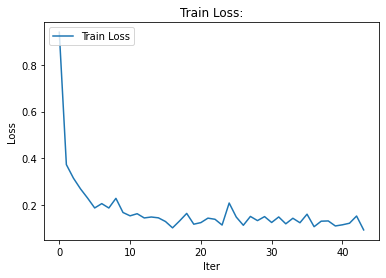

In [183]:
print_loss(model_R["train_loss"][1:])

Нестабильная модель

GRU

In [184]:
class SalaryPredictor_GRU(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, length=35, bidirectional=False):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.gru = nn.GRU(length, hid_size, 2)
        self.title_encoder = nn.Sequential(
            nn.GroupNorm(hid_size, hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.GroupNorm(hid_size, hid_size),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features, (_h, _h) = self.gru(title_embeddings)
        title_features = self.title_encoder(title_features).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features, (_h, _c) = self.gru(description_embeddings)
        description_features = self.description_encoder(description_features).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [185]:
model = SalaryPredictor_GRU().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_GRU = train_new(model, 3, data_train, data_val, optimizer, criterion)

epoch 1/3..


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss: 1.2779992818832397
val results:
Mean square error: 0.16324
Mean absolute error: 0.16785
train_loss: 0.5703105926513672
val results:
Mean square error: 0.29870
Mean absolute error: 0.24732
train_loss: 0.3705933094024658
val results:
Mean square error: 0.32401
Mean absolute error: 0.26452
train_loss: 0.32090118527412415
val results:
Mean square error: 0.25902
Mean absolute error: 0.23382
train_loss: 0.24699915945529938
val results:
Mean square error: 0.19910
Mean absolute error: 0.20096
train_loss: 0.16905733942985535
val results:
Mean square error: 0.18990
Mean absolute error: 0.19580
train_loss: 0.16851189732551575
val results:
Mean square error: 0.14371
Mean absolute error: 0.16577
train_loss: 0.15663780272006989
val results:
Mean square error: 0.15660
Mean absolute error: 0.17491
train_loss: 0.18602904677391052
val results:
Mean square error: 0.13804
Mean absolute error: 0.16210
train_loss: 0.1602291315793991
val results:
Mean square error: 0.14202
Mean absolute error: 0.

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss: 0.1662893444299698
val results:
Mean square error: 0.10725
Mean absolute error: 0.13936
train_loss: 0.14373818039894104
val results:
Mean square error: 0.10277
Mean absolute error: 0.13587
train_loss: 0.1494412124156952
val results:
Mean square error: 0.09573
Mean absolute error: 0.13012
train_loss: 0.1565733551979065
val results:
Mean square error: 0.11013
Mean absolute error: 0.14179
train_loss: 0.13034695386886597
val results:
Mean square error: 0.09327
Mean absolute error: 0.12773
train_loss: 0.12674663960933685
val results:
Mean square error: 0.10731
Mean absolute error: 0.13943
train_loss: 0.13152949512004852
val results:
Mean square error: 0.09879
Mean absolute error: 0.13290
train_loss: 0.1076468825340271
val results:
Mean square error: 0.07804
Mean absolute error: 0.11516
train_loss: 0.11813858151435852
val results:
Mean square error: 0.09525
Mean absolute error: 0.13031
train_loss: 0.12947389483451843
val results:
Mean square error: 0.08331
Mean absolute error: 0.

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss: 0.1701699197292328
val results:
Mean square error: 0.08341
Mean absolute error: 0.12080
train_loss: 0.1257094144821167
val results:
Mean square error: 0.09778
Mean absolute error: 0.13325
train_loss: 0.19499990344047546
val results:
Mean square error: 0.08388
Mean absolute error: 0.12107
train_loss: 0.11720594763755798
val results:
Mean square error: 0.08795
Mean absolute error: 0.12467
train_loss: 0.12684975564479828
val results:
Mean square error: 0.08481
Mean absolute error: 0.12239
train_loss: 0.13787710666656494
val results:
Mean square error: 0.08577
Mean absolute error: 0.12327
train_loss: 0.12727704644203186
val results:
Mean square error: 0.06757
Mean absolute error: 0.10649
train_loss: 0.16056981682777405
val results:
Mean square error: 0.07818
Mean absolute error: 0.11659
train_loss: 0.12125464528799057
val results:
Mean square error: 0.08066
Mean absolute error: 0.11888
train_loss: 0.1246856153011322
val results:
Mean square error: 0.07826
Mean absolute error: 0

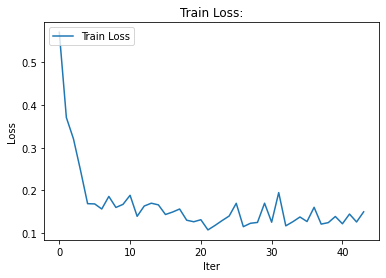

In [192]:
print_loss(model_GRU["train_loss"][1:])

Тоже нестабильна, но показатели лучше, чем у lstm

Двунаправленная

In [197]:
class SalaryPredictor_BI(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, length=35, bidirectional=True):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.gru = nn.GRU(length, hid_size,bidirectional = bidirectional) #Тут добавляем параметр
        self.title_encoder = nn.Sequential(
            nn.GroupNorm(hid_size, hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.GroupNorm(hid_size, hid_size),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features, (_h, _h) = self.gru(title_embeddings)
        title_features = self.title_encoder(title_features).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features, (_h, _c) = self.gru(description_embeddings)
        description_features = self.description_encoder(description_features).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [198]:
model = SalaryPredictor_BI().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_BI = train_new(model, 3, data_train, data_val, optimizer, criterion)

epoch 1/3..


  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss: 26.564044952392578
val results:
Mean square error: 7.54698
Mean absolute error: 1.36724
train_loss: 0.5486671924591064
val results:
Mean square error: 0.26019
Mean absolute error: 0.22193
train_loss: 0.5114943981170654
val results:
Mean square error: 0.29350
Mean absolute error: 0.24352
train_loss: 0.3307286500930786
val results:
Mean square error: 0.28565
Mean absolute error: 0.24263
train_loss: 0.34175461530685425
val results:
Mean square error: 0.28669
Mean absolute error: 0.24514
train_loss: 0.25647273659706116
val results:
Mean square error: 0.25239
Mean absolute error: 0.22862
train_loss: 0.23617789149284363
val results:
Mean square error: 0.27518
Mean absolute error: 0.24149
train_loss: 0.21076634526252747
val results:
Mean square error: 0.24805
Mean absolute error: 0.22791
train_loss: 0.22125017642974854
val results:
Mean square error: 0.22110
Mean absolute error: 0.21351
train_loss: 0.20179325342178345
val results:
Mean square error: 0.20818
Mean absolute error: 0.

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss: 0.13324695825576782
val results:
Mean square error: 0.12846
Mean absolute error: 0.15572
train_loss: 0.1305992305278778
val results:
Mean square error: 0.13923
Mean absolute error: 0.16366
train_loss: 0.14968398213386536
val results:
Mean square error: 0.11593
Mean absolute error: 0.14657
train_loss: 0.12828224897384644
val results:
Mean square error: 0.11927
Mean absolute error: 0.14901
train_loss: 0.13767744600772858
val results:
Mean square error: 0.11483
Mean absolute error: 0.14586
train_loss: 0.12526147067546844
val results:
Mean square error: 0.10818
Mean absolute error: 0.14070
train_loss: 0.13929395377635956
val results:
Mean square error: 0.09470
Mean absolute error: 0.12972
train_loss: 0.1455746591091156
val results:
Mean square error: 0.10629
Mean absolute error: 0.13929
train_loss: 0.158750981092453
val results:
Mean square error: 0.09241
Mean absolute error: 0.12778
train_loss: 0.12721529603004456
val results:
Mean square error: 0.07677
Mean absolute error: 0.

  0%|          | 0/1548 [00:00<?, ?it/s]

train_loss: 0.12884917855262756
val results:
Mean square error: 0.09497
Mean absolute error: 0.13042
train_loss: 0.1418185979127884
val results:
Mean square error: 0.08898
Mean absolute error: 0.12539
train_loss: 0.13216960430145264
val results:
Mean square error: 0.08066
Mean absolute error: 0.11820
train_loss: 0.11520226299762726
val results:
Mean square error: 0.08150
Mean absolute error: 0.11883
train_loss: 0.16301394999027252
val results:
Mean square error: 0.08649
Mean absolute error: 0.12370
train_loss: 0.14788541197776794
val results:
Mean square error: 0.07225
Mean absolute error: 0.11040
train_loss: 0.15511366724967957
val results:
Mean square error: 0.07902
Mean absolute error: 0.11672
train_loss: 0.09102761000394821
val results:
Mean square error: 0.08899
Mean absolute error: 0.12575
train_loss: 0.10434741526842117
val results:
Mean square error: 0.07890
Mean absolute error: 0.11697
train_loss: 0.16450059413909912
val results:
Mean square error: 0.08061
Mean absolute error:

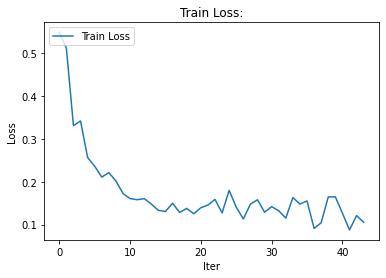

In [199]:
print_loss(model_BI["train_loss"][1:])

Под конец становится нестабильной, но mse хороший


5. Вытащите признаки из нейронной сети и используйте их в ансамбле деревьев решений.

Вытащите признаки с предпоследнего слоя обученной нейросети и передайте их в ансамбль деревьев решений.

In [ ]:
model = SalaryPredictor()
output = model(batch)

In [ ]:
model.train()

SalaryPredictor(
  (embedder): Embedding(34158, 8)
  (title_encoder): Sequential(
    (0): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): ReLU()
    (4): AdaptiveMaxPool1d(output_size=1)
  )
  (description_encoder): Sequential(
    (0): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): ReLU()
    (4): AdaptiveMaxPool1d(output_size=1)
  )
  (categorical_encoder): Sequential(
    (0): Linear(in_features=3768, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (final_predictor): S

In [ ]:
new_model = nn.Sequential(*list(model.modules())[:-1])

In [ ]:
new_model

Sequential(
  (0): SalaryPredictor(
    (embedder): Embedding(34158, 8)
    (title_encoder): Sequential(
      (0): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.25, inplace=False)
      (3): ReLU()
      (4): AdaptiveMaxPool1d(output_size=1)
    )
    (description_encoder): Sequential(
      (0): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.25, inplace=False)
      (3): ReLU()
      (4): AdaptiveMaxPool1d(output_size=1)
    )
    (categorical_encoder): Sequential(
      (0): Linear(in_features=3768, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=16, out_features=16, bias=True)
      (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_r

Тут не очень получилось

In [ ]:
# import lightgbm as lgb
# clf = lgb.LGBMClassifier()
emb_test = pd.DataFrame(new_model(batch))
# clf.train(emb_test, y = test_data[target])

RuntimeError: ignored